### Running Palace Simulations on GDSFactory+ Cloud


In [ ]:
from gsim.palace import PalaceSim
# !uv pip install git+https://github.com/gdsfactory/IHP.git --upgrade

In [2]:
# === Configuration ===
OUTPUT_DIR = "./palace-sim-cpw"

### Load a pcell from IHP PDK

2026-01-21 14:58:06.645 | WARNING  | doroutes.pcells:<module>:25 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-01-21 14:58:06.658 | WARNING  | doroutes.pcells:<module>:48 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-01-21 14:58:06.660 | WARNING  | doroutes.pcells:<module>:110 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-01-21 14:58:06.661 | WARNING  | doroutes.pcells:<module>:149 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-01-21 14:58:06.662 | WARNING  | doroutes.pcells:<module>:168 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to con

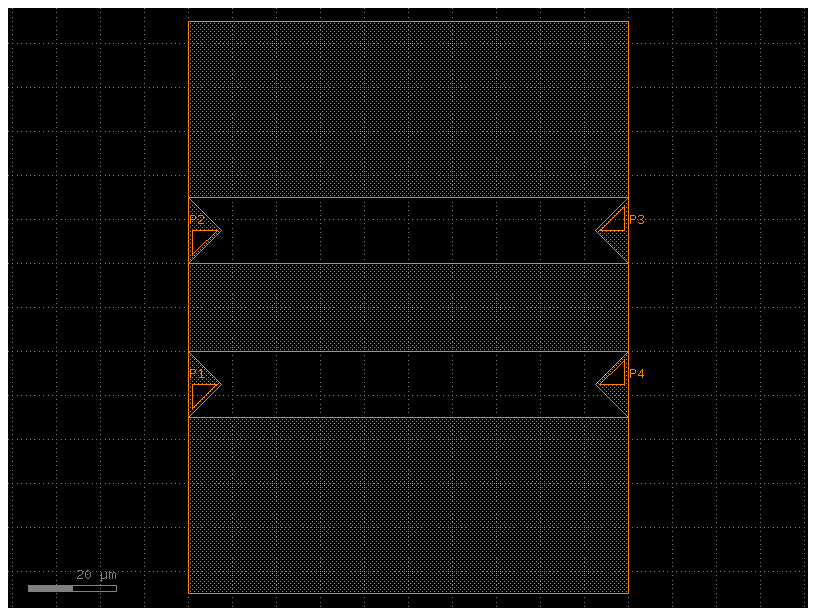

In [3]:
# Import ihp first to avoid circular import issues
from ihp import LAYER, PDK

import gdsfactory as gf

PDK.activate()


@gf.cell
def gsg_electrode(
    length: float = 100,
    s_width: float = 20,
    g_width: float = 40,
    gap_width: float = 15,
    layer=LAYER.TopMetal2drawing,
) -> gf.Component:
    """
    Create a GSG (Ground-Signal-Ground) electrode.

    Args:
        length: horizontal length of the electrodes
        s_width: width of the signal (center) electrode
        g_width: width of the ground electrodes
        gap_width: gap between signal and ground electrodes
        layer: layer for the metal
    """
    c = gf.Component()

    # Top ground electrode
    r1 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r1.move((0, (g_width + s_width) / 2 + gap_width))

    # Center signal electrode
    _r2 = c << gf.c.rectangle((length, s_width), centered=True, layer=layer)

    # Bottom ground electrode
    r3 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r3.move((0, -(g_width + s_width) / 2 - gap_width))

    # Add ports at the gaps
    c.add_port(
        name="P1",
        center=(-length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P2",
        center=(-length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P3",
        center=(length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P4",
        center=(length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    return c


c = gsg_electrode()
cc = c.copy()
cc.draw_ports()
cc

### Configure and run simulation with fluent API

In [4]:
# Create simulation object
sim = PalaceSim()

# Set the component geometry
sim.geometry(c)

# Configure layer stack from active PDK
sim.stack(substrate_thickness=2.0, air_above=300.0)

# Configure left CPW port (P1 lower, P2 upper)
sim.cpw_port("P2", "P1", layer="topmetal2", length=5.0)

# Configure right CPW port (P4 lower, P3 upper)
sim.cpw_port("P3", "P4", layer="topmetal2", length=5.0)

# Configure driven simulation (frequency sweep for S-parameters)
# This replaces the deprecated .physics() method
sim.driven(fmin=1e9, fmax=100e9, num_points=40)

# Set mesh parameters (presets: "coarse", "default", "fine")
sim.mesh(preset="default")

# Validate configuration
print(sim.validate())

Validation: PASSED


In [5]:
# Generate mesh locally
result = sim.run(OUTPUT_DIR)

Generating mesh in palace-sim-cpw...
Mesh saved: palace-sim-cpw/palace.msh
Config saved: palace-sim-cpw/config.json


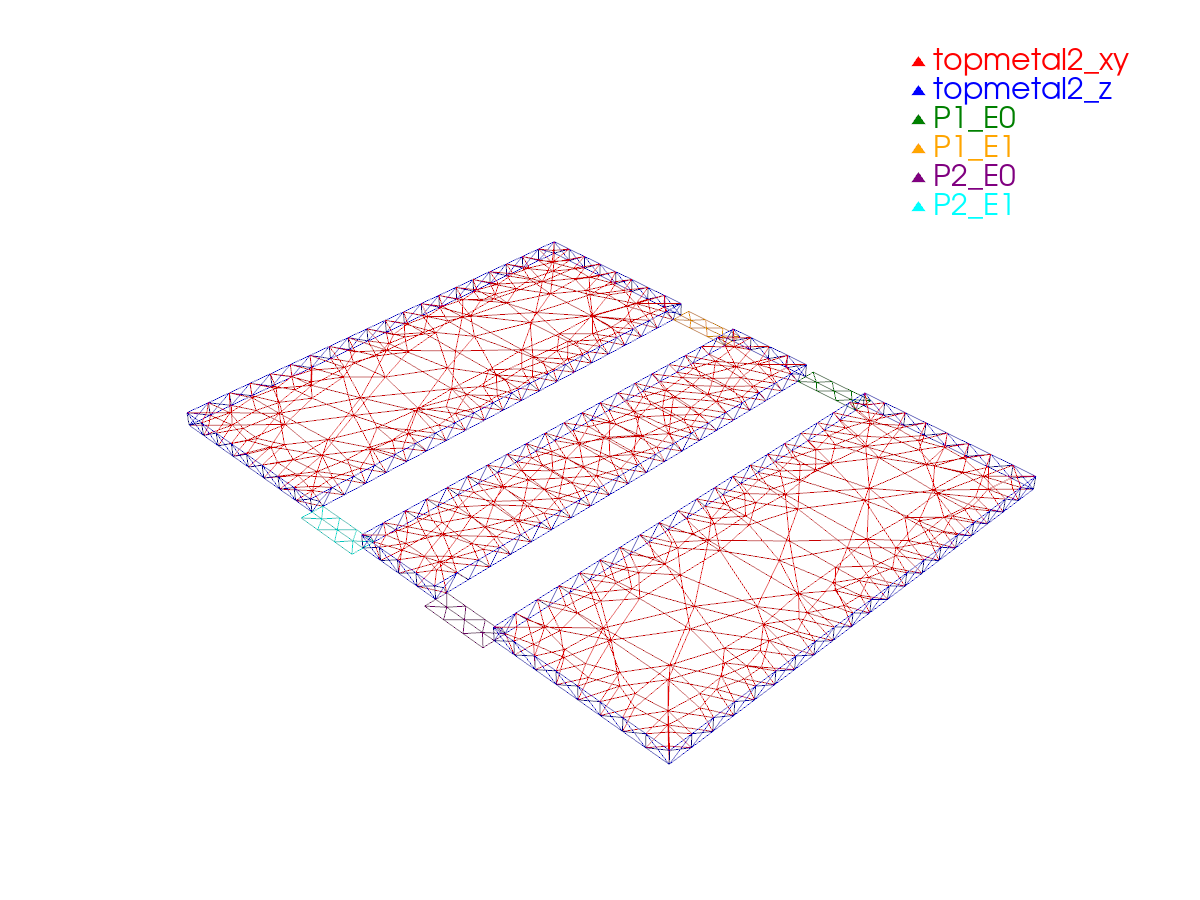

In [6]:
from gsim.palace import plot_mesh

# Static PNG
plot_mesh(
    f"{OUTPUT_DIR}/palace.msh",
    output=f"{OUTPUT_DIR}/mesh.png",
    show_groups=["metal", "P"],
    interactive=False,
)

# Interactive
# plot_mesh(f"{OUTPUT_DIR}/palace.msh", show_groups=["metal", "P"], interactive=True)

### Run simulation on GDSFactory+ Cloud

In [7]:
# Option 1: Run on cloud directly with PalaceSim
# result = sim.run(OUTPUT_DIR, cloud=True)

# Option 2: Run separately after mesh generation
from gsim.palace import run_simulation

results = run_simulation(OUTPUT_DIR)

Uploading simulation... done
Job started: dev-palace-simulation-8c723e4d
Created: 13:58:11 | Now: 14:12:38 | Status: completed
Downloaded 6 files to /Users/vahid/doplaydo/gsim/nbs/dev-palace-simulation-8c723e4d


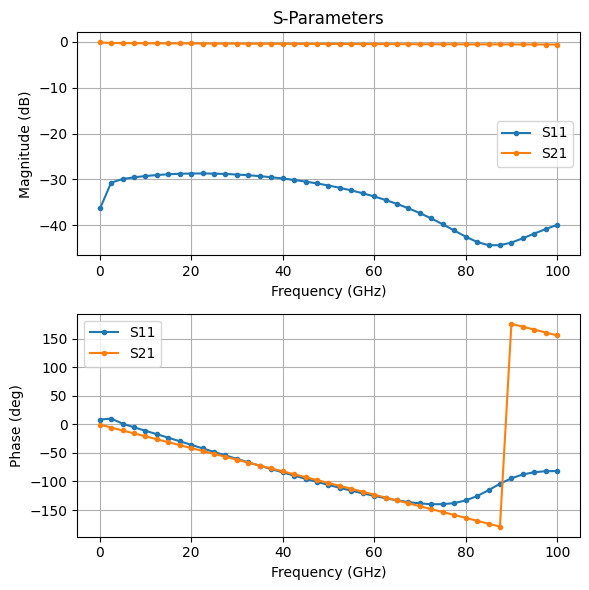

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(results["port-S.csv"])
df.columns = df.columns.str.strip()  # Remove whitespace from column names

freq = df["f (GHz)"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Magnitude plot
ax1.plot(freq, df["|S[1][1]| (dB)"], marker=".", label="S11")
ax1.plot(freq, df["|S[2][1]| (dB)"], marker=".", label="S21")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("S-Parameters")
ax1.legend()
ax1.grid(True)

# Phase plot
ax2.plot(freq, df["arg(S[1][1]) (deg.)"], marker=".", label="S11")
ax2.plot(freq, df["arg(S[2][1]) (deg.)"], marker=".", label="S21")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase (deg)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()